In [1]:
# import some of the libaries that we will use
import urllib.request
import io
import itertools as it
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import re
import unicodedata
import string

from thefuzz import process
from thefuzz import fuzz

import json

import colorcet as cc
import panel as pn
import panel.widgets as pnw

from translate_app import translate_list_to_dict
import recordlinkage as rl
import missingno as msno
import holoviews as hv
from holoviews import streams
from holoviews.selection import link_selections
from holoviews import opts
import hvplot
import hvplot.pandas
import geoviews as gv
import geopandas as gpd
import cartopy.crs as ccrs
from panel.template import FastListTemplate

In [2]:
pn.extension(template="fast", sizing_mode="stretch_width")
pn.config.throttled = True
hv.extension("bokeh")
gv.extension("bokeh")
# don't show pandas warning
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 40)

In [3]:
pd.set_option("display.max_rows", 200)


def remove_accents(input_str):
    """Function to remove accents from a string.
    It takes as argument a string and returns the same string
    without accents."""
    nfkd_form = (
        unicodedata.normalize("NFKD", input_str).encode(
            "ASCII", "ignore").decode()
    )
    # return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return nfkd_form


remove_accents("résuméö")

'resumeo'

In [4]:
# get the zip file with the data from the link

data_url = (
    "https://storage.googleapis.com/mrprime_dataset/dogs_of_zurich/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [5]:
# Shapefile for Zurich
zurich_shapefile = "../data/zurich_shape_data.zip"

# Get the path to the shapefile within the zip archive
shapefile_path = "zip://" + zurich_shapefile + "!data/stzh.adm_stadtkreise_v.shp"

# Description of zurich districts
zurich_desc_path = "../data/zurich_districts.csv"

# Read the shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# read in csv as a pandas dataframe
zurich_desc = pd.read_csv(zurich_desc_path)

# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)

In [6]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan,
           dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [7]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

We run the translation app on 
- the columns names.
- the dog breeds
- the dog colors

In [8]:
translated_words = translate_list_to_dict(words_set, project_id="mrprimetranslator")


translated_words

{'HUNDERASSE': 'DOG BREED',
 'RASSENTYP': 'BREED TYPE',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED',
 'RASSE1': 'BREED1',
 'GESCHLECHT': 'GENDER',
 'HUNDEFARBE': 'DOG COLOR',
 'roster': 'roster',
 'RASSE2': 'BREED2',
 'ALTER': 'AGE',
 'STADTKREIS': 'CITY CIRCLE',
 'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'GESCHLECHT HUND': 'GENDER DOG',
 'Rassentypenliste II': 'List of breed types II',
 'HALTER ID': 'HOLDER ID',
 'STADTQUARTIER': 'CITY QUARTER',
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED',
 'Kleinwüchsig': 'Short stature',
 'Rassentypenliste I': 'Breed type list I',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'HUNDERASSENTYP': 'DOG BREED TYPE'}

In [9]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'HUNDERASSE': 'dog_breed',
 'RASSENTYP': 'breed_type',
 'RASSE1_MISCHLING': 'breed1_mixed_breed',
 'RASSE1': 'breed1',
 'GESCHLECHT': 'gender',
 'HUNDEFARBE': 'dog_color',
 'roster': 'roster',
 'RASSE2': 'breed2',
 'ALTER': 'age',
 'STADTKREIS': 'city_circle',
 'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'GESCHLECHT_HUND': 'gender_dog',
 'Rassentypenliste_II': 'list_of_breed_types_ii',
 'HALTER_ID': 'holder_id',
 'STADTQUARTIER': 'city_quarter',
 'RASSE2_MISCHLING': 'breed2_mixed_breed',
 'Kleinwüchsig': 'short_stature',
 'Rassentypenliste_I': 'breed_type_list_i',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'HUNDERASSENTYP': 'dog_breed_type'}

In [10]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"

In [11]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [12]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [dogs_of_zurich_dfs[0], dogs_of_zurich_dfs[1], dogs_of_zurich_dfs[2]], axis=0
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holder_id           21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [13]:
display(dog_owner_df.sample(3))
dog_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
5461,122648,31-40,w,7.0,71.0,Pekingese,NaN,NaN,NaN,K,2012,w,rot/weiss,20160307hundehalter.csv
4232,115065,41-50,w,8.0,83.0,Havaneser,NaN,NaN,NaN,K,2012,m,beige,20170308hundehalter.csv
1685,87386,41-50,m,8.0,83.0,Shih Tzu,NaN,NaN,NaN,K,2003,w,tricolor,20151001hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
310,Soft Coated Wheaten Terrier,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
210,Luzerner Niederlaufhund,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
23,Australian Terrier,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv


,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
5035,119569,21-30,w,11.0,111.0,Zwergspitz,NaN,Pomeranian,NaN,K,2011,w,weiss,20160307hundehalter.csv
3480,104980,41-50,m,12.0,122.0,Pinscher,NaN,Mops,NaN,K,2015,w,beige,20170308hundehalter.csv
3464,104765,71-80,w,7.0,74.0,Dackel,NaN,Yorkshire Terrier,NaN,K,2014,m,grau/beige,20170308hundehalter.csv
5276,121523,41-50,w,1.0,11.0,Labradoodle,NaN,Pudel,NaN,I,2014,m,creme,20160307hundehalter.csv
3469,104830,51-60,w,9.0,91.0,Yorkshire Terrier,Mischling,NaN,NaN,K,2008,w,dunkel gestromt,20170308hundehalter.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158,118192,61-70,w,2.0,24.0,Biewer Yorkshire Terrier,NaN,NaN,NaN,NaN,2013,m,schwarz,20151001hundehalter.csv
6785,127555,41-50,w,3.0,34.0,Pudel,NaN,NaN,NaN,NaN,2009,w,apricot,20151001hundehalter.csv
2556,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,NaN,K,1998,w,schwarz,20151001hundehalter.csv
2407,90344,NaN,m,NaN,NaN,Shih Tzu,NaN,NaN,NaN,K,1998,w,schwarz,20160307hundehalter.csv


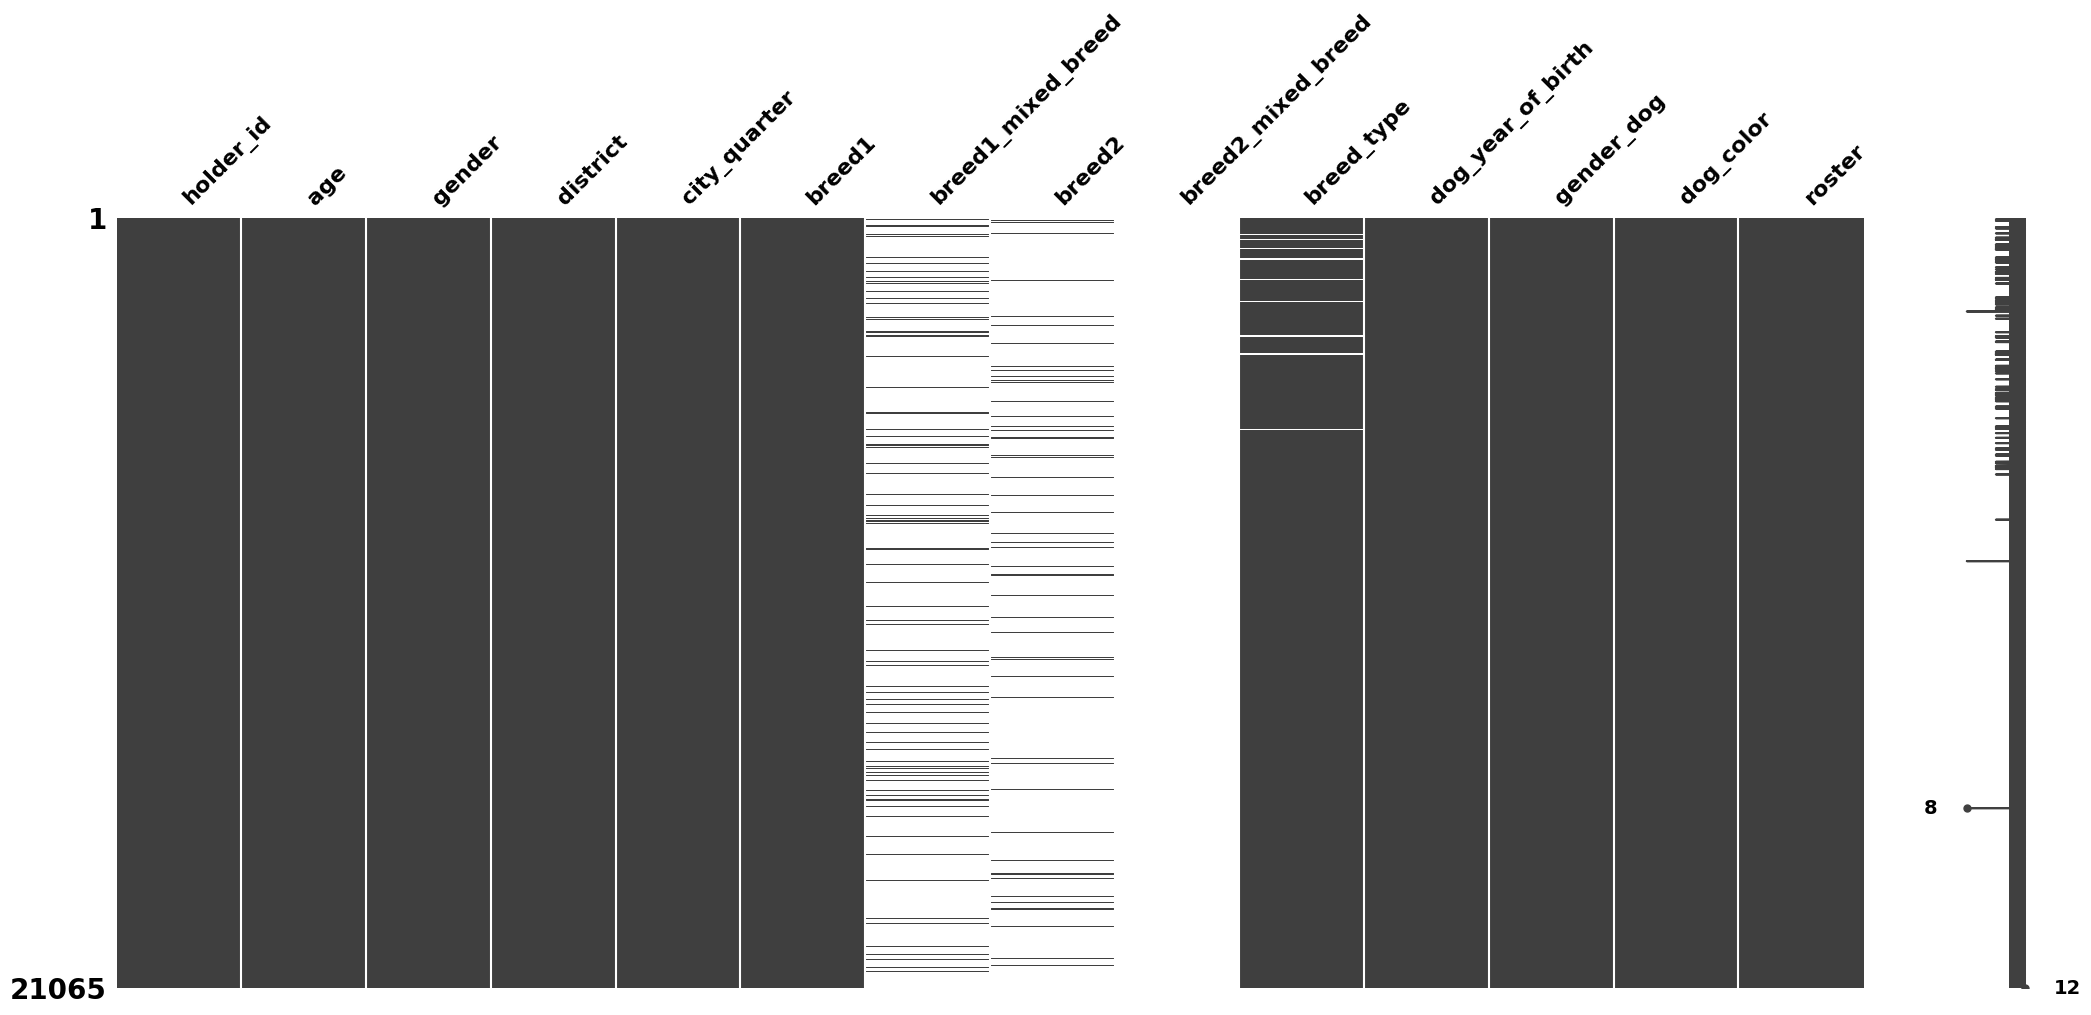

In [14]:
msno.matrix(dog_owner_df)

msno.nullity_sort(dog_owner_df, sort="descending")

In [15]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

In [16]:
"""
This code snippet performs various operations on the 'dog_owner_df' DataFrame:

1. Resets the index of the DataFrame.
2. Converts the 'district' column to a categorical data type.
3. Converts all the breed columns ('breed1', 'breed2', 'breed1_mixed_breed') to lowercase.
4. Takes the first 4 characters of the 'roster' column and converts it to an ordered categorical column.
5. Adds a column 'first_roster' that represents the first year the owner appeared in the roster.
6. Adds a column 'roster_count' that represents the number of unique rosters each owner appeared in.
7. Adds a column 'dog_count' that represents the number of dogs per owner in each roster.
8. Adds a column 'district_count' that represents the number of unique districts each owner appeared in.

9. Converts the 'holder_id' column to a string data type.
10. Adds a column 'is_male_owner' that indicates whether the owner is male or not based on the 'gender' column.
11. Adds a column 'is_male_dog' that indicates whether the dog is male or not based on the 'gender_dog' column.
"""

dog_owner_df = dog_owner_df.reset_index(drop=True)

dog_owner_df["district"] = dog_owner_df["district"].astype("category")

dog_owner_df["breed1"] = dog_owner_df["breed1"].str.lower()

dog_owner_df["breed2"] = dog_owner_df["breed2"].str.lower()

dog_owner_df["breed1_mixed_breed"] = dog_owner_df["breed1_mixed_breed"].str.lower()

dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]

dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)

dog_owner_df["first_roster"] = dog_owner_df.groupby("holder_id")["roster"].transform(
    "min"
)

dog_owner_df["roster_count"] = dog_owner_df.groupby("holder_id")["roster"].transform(
    "nunique"
)

dog_owner_df["dog_count"] = dog_owner_df.groupby(["holder_id", "roster"])[
    "holder_id"
].transform("size")

dog_owner_df["district_count"] = (
    dog_owner_df[["holder_id", "district"]]
    .groupby("holder_id")["district"]
    .transform("nunique")
)

dog_owner_df["holder_id"] = dog_owner_df["holder_id"].astype(str)
dog_owner_df["is_male_owner"] = dog_owner_df["gender"].str.contains("m")
dog_owner_df["is_male_dog"] = dog_owner_df["gender_dog"].str.contains("m")
dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
11816,117843,31-40,w,7.0,74.0,husky,mischling,NaN,I,2013,w,braun/weiss,2016,2015,2,1,1,False,False
19263,124556,51-60,w,4.0,42.0,chihuahua,NaN,NaN,K,2011,m,schwarz/weiss,2017,2015,3,1,1,False,True
11352,112434,41-50,w,12.0,123.0,border collie,mischling,NaN,I,2012,m,schwarz/weiss,2016,2015,2,1,1,False,True


In [17]:
print(f"Number of holders: {dog_owner_df['holder_id'].nunique()}")

Number of holders: 7726


Dog with a year of birth after the roster year

In [18]:
# get the holder_id of the bad entries and observe other entries with the same holder_id
bad_entry_holder_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["holder_id"]


dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

# dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].index

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
4543,111954,41-50,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2015,2015,2,1,1,False,True
11296,111954,51-60,w,3.0,34.0,parson russell terrier,NaN,NaN,K,5012,m,tricolor,2016,2015,2,1,1,False,True
5608,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2015,2015,3,1,1,True,True
12282,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2016,2015,3,1,1,True,True
18798,121585,41-50,m,7.0,74.0,malteser,NaN,NaN,K,2016,m,weiss,2017,2015,3,1,1,True,True


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [19]:
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id)
].index

dog_owner_df.drop(bad_entry_index, inplace=True)

dog_owner_df.info()

(21065, 19)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21060 non-null  object  
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_roster        21060 non-null  category
 14  roster_count        21060 non-null  int64   
 15  dog_count           21060 non-null  

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [20]:
# get the holder_id of the bad entries
bad_entry_holder_id = dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990][
    "holder_id"
]

# isolate entries from these holder_ids and group them by holder_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)]
    .sort_values(by="holder_id")
    .groupby("holder_id")
)

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,1962,m,braun/schwarz,2015,2015,3,1,1,False,True
10304,100070,51-60,w,9.0,91.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2016,2015,3,1,1,False,True
16990,100070,51-60,w,9.0,91.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2017,2015,3,1,1,False,True
13666,129251,31-40,w,10.0,101.0,kleiner münsterländer,NaN,NaN,I,1980,w,braun/weiss,2016,2016,1,1,1,False,False
2659,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,1980,w,beige/schwarz,2015,2015,3,1,1,True,False
9485,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1,1,True,False
16238,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1,1,True,False
2901,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,8,w,braun,2015,2015,3,1,1,False,False
9712,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1,1,False,False
16448,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1,1,False,False


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for th elater rosters. Luckly these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it.

In [21]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["holder_id"].isin(bad_entry_holder_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["holder_id"].isin(bad_entry_holder_id)].sort_values(
    by="holder_id"
)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog
3521,100070,51-60,w,9.0,92.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2015,2015,3,1,1,False,True
10304,100070,51-60,w,9.0,91.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2016,2015,3,1,1,False,True
16990,100070,51-60,w,9.0,91.0,pekingese,NaN,NaN,K,2006,m,braun/schwarz,2017,2015,3,1,1,False,True
13666,129251,31-40,w,10.0,101.0,kleiner münsterländer,NaN,NaN,I,1980,w,braun/weiss,2016,2016,1,1,1,False,False
2659,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2015,2015,3,1,1,True,False
9485,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2016,2015,3,1,1,True,False
16238,91351,41-50,m,7.0,72.0,mops,NaN,NaN,K,2009,w,beige/schwarz,2017,2015,3,1,1,True,False
2901,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2015,2015,3,1,1,False,False
9712,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2016,2015,3,1,1,False,False
16448,94655,41-50,w,2.0,24.0,labrador retriever,NaN,NaN,I,2008,w,braun,2017,2015,3,1,1,False,False


In [22]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(
    dog_owner_df[dog_owner_df["holder_id"] == 129251].index
)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["holder_id"]

13666    129251
Name: holder_id, dtype: object

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [23]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)
dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age
763,82878,61-70,m,7.0,71.0,zwergschnauzer,NaN,NaN,K,2011,m,weiss,2015,2015,3,1,1,True,True,5
4465,111038,51-60,w,8.0,83.0,mischling gross,NaN,NaN,I,2011,w,black/tan,2015,2015,3,1,1,False,False,5
14046,67180,51-60,w,1.0,11.0,english cocker spaniel,NaN,NaN,K,2004,w,blauschimmel,2017,2015,3,1,1,False,False,14


In [24]:
dog_owner_df["dog_age"].describe()

count    21060.000000
mean         8.022602
std          4.112475
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         37.000000
Name: dog_age, dtype: float64

In [25]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age
1348,85988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2015,2015,2,1,1,True,True,15
2556,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2015,2015,3,1,0,True,False,18
8253,85988,NaN,m,2.0,2.0,zwergpudel,NaN,NaN,K,2001,m,beige/weiss,2016,2015,2,1,1,True,True,16
9387,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2016,2015,3,1,0,True,False,19
16144,90344,NaN,m,NaN,NaN,shih tzu,NaN,NaN,K,1998,w,schwarz,2017,2015,3,1,0,True,False,20


(21055, 20)

In [26]:
# owners each year
owner_2015 = set(dog_owner_df[dog_owner_df["roster"] == "2015"]["holder_id"])
owner_2016 = set(dog_owner_df[dog_owner_df["roster"] == "2016"]["holder_id"])
owner_2017 = set(dog_owner_df[dog_owner_df["roster"] == "2017"]["holder_id"])

print(f"{len(owner_2015)} initial owners in 2015")
# constant owners for all 3 years
new_2016 = owner_2016.difference(owner_2015)
returning_2016 = owner_2016.intersection(owner_2015)
left_2016 = owner_2015.difference(owner_2016)
print(
    f"{len(new_2016)} new owners in 2016 and {len(returning_2016)} returning owners and {len(left_2016)} owners left in 2016"
)

new_2017 = owner_2017.difference(owner_2015.union(owner_2016))
returning_2017 = owner_2017.intersection(owner_2015.union(owner_2016))
left_2017 = owner_2016.difference(owner_2017)
print(
    f"{len(new_2017)} new owners in 2017 and {len(returning_2017)} returning owners and {len(left_2017)} owners left in 2017"
)

constistent_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constistent_owners)} constant owners")
#
# see if any owners owned in 2015 and 2017, but not 2016
gap_owners = owner_2015.intersection(owner_2017).difference(owner_2016)
print(f"{len(gap_owners)} owners with a gap year")

6312 initial owners in 2015
435 new owners in 2016 and 5836 returning owners and 476 owners left in 2016
975 new owners in 2017 and 5471 returning owners and 831 owners left in 2017
5074 constant owners
31 owners with a gap year


In [27]:
def get_owners(dog_owner_df, year):
    return set(dog_owner_df[dog_owner_df["roster"] == year]["holder_id"])


def get_new_owners(owner_current_year, owner_previous_year):
    return owner_current_year.difference(owner_previous_year)


def get_returning_owners(owner_current_year, owner_previous_year):
    return owner_current_year.intersection(owner_previous_year)


def get_left_owners(owner_current_year, owner_previous_year):
    return owner_previous_year.difference(owner_current_year)


# Get owners for each year
owner_2015 = get_owners(dog_owner_df, "2015")
owner_2016 = get_owners(dog_owner_df, "2016")
owner_2017 = get_owners(dog_owner_df, "2017")

# Print the number of initial owners in 2015
print(f"{len(owner_2015)} initial owners in 2015")

# Calculate and print the new, returning, and left owners for 2016
new_2016 = get_new_owners(owner_2016, owner_2015)
returning_2016 = get_returning_owners(owner_2016, owner_2015)
left_2016 = get_left_owners(owner_2016, owner_2015)
print(
    f"{len(new_2016)} new owners in 2016, {len(returning_2016)} returning owners, and {len(left_2016)} owners left in 2016"
)

# Calculate and print the new, returning, and left owners for 2017
new_2017 = get_new_owners(owner_2017, owner_2016.union(owner_2015))
returning_2017 = get_returning_owners(owner_2017, owner_2016.union(owner_2015))
left_2017 = get_left_owners(owner_2017, owner_2016)
print(
    f"{len(new_2017)} new owners in 2017, {len(returning_2017)} returning owners, and {len(left_2017)} owners left in 2017"
)

# Calculate and print the constant owners
constant_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constant_owners)} constant owners")

# Calculate and print the gap owners
gap_owners = owner_2015.intersection(owner_2017).difference(owner_2016)
print(f"{len(gap_owners)} owners with a gap year")

6312 initial owners in 2015
435 new owners in 2016, 5836 returning owners, and 476 owners left in 2016
975 new owners in 2017, 5471 returning owners, and 831 owners left in 2017
5074 constant owners
31 owners with a gap year


In [28]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)

In [29]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
dog_owner_df

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,age_group
0,126,51-60,m,9.0,92.0,welsh terrier,NaN,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,1,True,False,5,51-60
1,574,61-70,w,2.0,23.0,cairn terrier,NaN,NaN,K,2002,w,brindle,2015,2015,3,1,1,False,False,14,61-70
2,695,41-50,m,6.0,63.0,labrador retriever,NaN,NaN,I,2012,w,braun,2015,2015,3,1,1,True,False,4,41-50
3,893,61-70,w,7.0,71.0,mittelschnauzer,NaN,NaN,I,2010,w,schwarz,2015,2015,3,1,1,False,False,6,61-70
4,1177,51-60,m,10.0,102.0,shih tzu,NaN,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,1,True,True,5,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,135718,31-40,m,9.0,91.0,mischling gross,NaN,NaN,I,2015,w,golden,2017,2017,1,1,1,True,False,3,31-40
21061,135725,31-40,w,7.0,74.0,boxer,NaN,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,1,False,False,2,31-40
21062,135726,11-20,w,11.0,111.0,pinscher,NaN,NaN,K,2016,w,schwarz,2017,2017,1,1,1,False,False,2,11-30
21063,135728,31-40,w,7.0,72.0,whippet,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,1,False,False,2,31-40


In [30]:
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

#### Missing values for breed type

In [31]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['terrier', 'pudel', 'miniature australien shepard', 'elo',
       'dogo canario', 'schwedischer vallhund', 'spaniel', 'daisy-dog',
       'deutscher jagdterrier', 'biewer yorkshire terrier'], dtype=object)

In [32]:
# Find these breeds in the dog_df and get the breed_type from there
dog_df.drop("roster", axis=1, inplace=True)
dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

,dog_breed,dog_breed_type_short,dog_breed_type


In [33]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "holder_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(
        lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
biewer yorkshire terrier      K              20
daisy-dog                     K               2
deutscher jagdterrier         K               4
dogo canario                  I               7
elo                           I               3
miniature australien shepard  K              14
pudel                         K             216
                              I               5
schwedischer vallhund         K               2
spaniel                       K              13
terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21055 entries, 0 to 21064
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21055 non-null  object  
 1   age                 21055 non-null  category
 2   gender              21055 non-null  object  
 3   district            21053 non-null  category
 4   city_quarter        21053 non-null  float64 
 5   breed1              21055 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1590 non-null   object  
 8   breed_type          21055 non-null  object  
 9   dog_year_of_birth   21055 non-null  int64   
 10  gender_dog          21055 non-null  object  
 11  dog_color           21055 non-null  object  
 12  roster              21055 non-null  category
 13  first_roster        21055 non-null  category
 14  roster_count        21055 non-null  int64   
 15  dog_count           21055 non-null  

In [34]:
missing_district_holder_id = dog_owner_df[dog_owner_df["district"].isna()][
    "holder_id"
].unique()

dog_owner_df[dog_owner_df["holder_id"].isin(missing_district_holder_id)]

# drop these missing rows with no district info
dog_owner_df.dropna(subset=["district"], inplace=True)

dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053 entries, 0 to 21064
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   holder_id           21053 non-null  object  
 1   age                 21053 non-null  category
 2   gender              21053 non-null  object  
 3   district            21053 non-null  category
 4   city_quarter        21053 non-null  float64 
 5   breed1              21053 non-null  object  
 6   breed1_mixed_breed  1939 non-null   object  
 7   breed2              1588 non-null   object  
 8   breed_type          21053 non-null  object  
 9   dog_year_of_birth   21053 non-null  int64   
 10  gender_dog          21053 non-null  object  
 11  dog_color           21053 non-null  object  
 12  roster              21053 non-null  category
 13  first_roster        21053 non-null  category
 14  roster_count        21053 non-null  int64   
 15  dog_count           21053 non-null  

In [35]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,age_group,age_range
4868,115541,71-80,w,2.0,21.0,chihuahua,NaN,NaN,K,2012,m,hellbraun,2015,2015,3,1,2,False,True,4,71+,70s
8805,88275,71-80,w,6.0,63.0,deutscher boxer,NaN,NaN,I,2004,m,dunkel gestromt,2016,2015,2,1,1,False,True,13,71+,70s
20696,133364,31-40,w,3.0,31.0,labrador retriever,NaN,NaN,I,2014,m,braun,2017,2017,1,1,1,False,True,4,31-40,30s


In [36]:
dog_owner_df["breed1_mixed_breed"].unique()
dog_owner_df["breed1_mixed_breed"].nunique()
dog_owner_df[breed_columns].describe()
# dog_df["dog_breed"].unique()
# dog_owner_df["breed1"].dropna().unique().tolist()

,breed1,breed2,breed1_mixed_breed,breed_type
count,21053,1588,1939,21053
unique,311,131,1,3
top,mischling klein,labrador retriever,mischling,K
freq,1905,121,1939,13219


#### Run translate app for breeds

In [37]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]
                           ].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan,
           dog_owner_df["breed1_mixed_breed"].unique())
)
breed_set = set(breed_list1 + breed_list2 + breed_list3)
breed_set = {breed.lower() for breed in breed_set}

display(len(breed_set))
# breed_set
translations_df = pd.DataFrame()
translations_df["breed"] = list(breed_set)
# sort the breeds alphabetically
translations_df.sort_values(by="breed", inplace=True)
translations_df.shape
translations_df["breed"] = translations_df["breed"].str.lower()
translations_df["translation"] = ""
trans_dict = translate_list_to_dict(translations_df["breed"].tolist())
translations_df["translation"] = translations_df["breed"].map(trans_dict)
translations_df

364

,breed,translation
66,affenpinscher,affenpinscher
295,afghane,Afghan
205,afghanischer windhund,Afghan hound
249,airedale terrier,airedale terrier
26,akita inu,akita inu
...,...,...
147,zwergpinscher,miniature pinscher
161,zwergpudel,miniature poodle
133,zwergrauhaardackel,miniature gray-haired dachshund
328,zwergschnauzer,miniature schnauzer


In [38]:
# get number of unique breeds in the translation column
translations_df["translation"].nunique()

355

#### Translate colors



In [39]:
# make 1 set of all the unique colors
color_set = set()

dog_colors_df = dog_owner_df["dog_color"].str.split("/", expand=True)
dog_colors_list = dog_colors_df.melt().value.unique().tolist()
dog_colors_list = [color for color in dog_colors_list if color is not None]
# dog_colors_list

# get translation for colors
dog_color_dict = translate_list_to_dict(dog_colors_list)

# dog_color_dict

In [40]:
dog_colors_en = dog_colors_df.applymap(dog_color_dict.get)
dog_colors_en.columns = ["color1", "color2", "color3"]
dog_owner_df = dog_owner_df.merge(dog_colors_en, left_index=True, right_index=True)

#### Get the AKC & FCI breeds saved to disk

We will use the AKC and FCI breeds list as a source of truth for the dog breed names.

In [41]:
# get the dog_breeds dataframe from the data folder
fci_breeds = pd.read_json("../data/fci_breeds.json", orient="records")
akc_breeds = pd.read_json("../data/akc_breeds.json", orient="records")

In [42]:
def find_breed_match(input_breed, breeds_df, scoring_function=fuzz.token_set_ratio):
    """Find the match for the breed in the FCI breeds dataframe."""
    max_score = 85
    best_match = np.nan
    for index, breed_row in breeds_df.iterrows():
        alternative_names = breed_row["alt_names"]
        current_score = max(
            scoring_function(input_breed, alt_name) for alt_name in alternative_names
        )
        if current_score > max_score:
            max_score = current_score
            best_match = breed_row["breed_en"]
        if max_score == 100:
            break

    return best_match


def apply_fuzzy_matching_to_breed_column(
    dataframe, breed_column, fci_df, fuzzy_matching_function
):
    """Apply fuzzy matching to the breed column in the dataframe."""
    return dataframe[breed_column].apply(
        lambda breed: find_breed_match(breed, fci_df, fuzzy_matching_function)
    )

Find the match first with the FCI list as it has a lot more than the AKC list. The search for a match is run onthe `alt_names` column since the breed can be referred to by any of its alternative names.

In [43]:
# Create the fci_breed column with NaNs
translations_df["standard"] = np.nan

# List of columns and fuzz functions to apply
columns = ["breed", "translation"]
fuzz_funcs = [
    fuzz.WRatio,
    fuzz.partial_ratio,
    # fuzz.ratio,
    # fuzz.token_sort_ratio,
    # fuzz.token_set_ratio,
]

# Apply each fuzz function to each column
for column in columns:
    for fuzz_func in fuzz_funcs:
        translations_df["standard"] = translations_df["standard"].fillna(
            apply_fuzzy_matching_to_breed_column(
                translations_df, column, fci_breeds, fuzz_func
            ),
        )
        print(f"Nulls left: {translations_df['standard'].isna().sum()}")

translations_df[translations_df["standard"].isna()].shape
# translations_df.shape

Nulls left: 48
Nulls left: 34
Nulls left: 21
Nulls left: 21


(21, 3)

In [44]:
translations_df[translations_df["standard"].isna()]

,breed,translation,standard
230,anatolian kangal,Anatolian Kangal,NaN
135,bardino,bardino,NaN
361,bichon löwenherz,bichon lionheart,NaN
291,bobtail,bobtail,NaN
308,bolonka zwetna,bolonka zwetna,NaN
252,corgie,corgie,NaN
264,dürbächler,dürbächler,NaN
220,elo gross,elo big,NaN
339,kleinspitz,small-pointed,NaN
145,mischling,hybrid,NaN


Follow up with the AKC list for some for which no match was found.

In [45]:
akc_breeds = akc_breeds[["breed", "alt_names"]]
akc_breeds["breed_en"] = akc_breeds["breed"].copy()
# remove None values from alt_names
akc_breeds["alt_names"] = akc_breeds["alt_names"].apply(lambda x: list(filter(None, x)))
akc_breeds

,breed,alt_names,breed_en
0,australian cattle dog,[australian cattle dog],australian cattle dog
1,australian shepherd,[australian shepherd],australian shepherd
2,bearded collie,"[collie, bearded collie]",bearded collie
3,beauceron,[beauceron],beauceron
4,belgian laekenois,[belgian laekenois],belgian laekenois
...,...,...,...
276,treeing tennessee brindle,[treeing tennessee brindle],treeing tennessee brindle
277,volpino italiano,[volpino italiano],volpino italiano
278,wetterhoun,[wetterhoun],wetterhoun
279,working kelpie,[working kelpie],working kelpie


In [46]:
# Apply each fuzz function to each column


for column in columns:
    for fuzz_func in fuzz_funcs:
        translations_df["standard"] = translations_df["standard"].fillna(
            apply_fuzzy_matching_to_breed_column(
                translations_df, column, akc_breeds, fuzz_func
            ),
        )
        # print(f"Nulls left: {translations_df['standard'].isna().sum()}")


translations_df[translations_df["standard"].isna()].shape

(15, 3)

In [47]:
# translations_df

In [48]:
# get an empty column of the dog_owner dataframe and map the fci_breed to the breed1 column

dog_owner_df = dog_owner_df.merge(
    translations_df, how="left", left_on="breed1", right_on="breed"
)
# dog_owner_df[["breed1", "fci_breed"]].sample(10)

Some we know there is no matching breed for like `Mischling` as this just means mixed in german.

In [49]:
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("mischling klein"), "standard"
] = "mixed breed small"
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("mischling gross"), "standard"
] = "mixed breed large"

In [50]:
dog_owner_df.loc[
    (dog_owner_df["breed1_mixed_breed"].notnull())
    | (dog_owner_df["breed2"].notnull())
    | (dog_owner_df["translation"].str.contains(r"mixed.*", regex=True)),
    "mixed_breed",
] = True
dog_owner_df["mixed_breed"].fillna(False, inplace=True)
dog_owner_df["pure_breed"] = ~dog_owner_df["mixed_breed"]
only_child_dogs = dog_owner_df[dog_owner_df["dog_count"] == 1]

In [51]:
# look for the count of the white swiss shepherd
dog_owner_df.standard.value_counts().head(20)

mixed breed small              1905
chihuahua                      1497
labrador retriever             1324
jack russell terrier           1002
yorkshire terrier               898
poodle                          885
dachshund                       618
maltese                         597
french bulldog                  571
pug                             531
mixed breed large               501
golden retriever                491
border collie                   306
west highland white terrier     296
english cocker spaniel          291
white swiss shepherd dog        280
appenzell cattle dog            273
russian tsvetnaya bolonka       270
beagle                          262
affenpinscher                   256
Name: standard, dtype: int64

#### Correction to the Shepherds

To fix mismatch of German Shepherd breed, we transate the colors and change the rows with the WHITE SWISS SHEPHERD DOG to the correct breed of GERMAN SHEPHERD DOG. Our fuzzy algorithm mistook Shepherd to mean white Swiss Shepherd instead of German Shepherd. While all of them would not German shepherds we can safely say that the ones that were not white were not white swiss shepherds.

In [52]:
coi = ["breed", "dog_color", "breed1", "breed2", "color1", "color2", "color3"]

german_shephard_tidying = dog_owner_df[
    dog_owner_df["breed1"].str.contains(r"^schäfer", case=False, regex=True, na=False)
][coi]
# check if white in any of the columns and put True in has_white column
german_shephard_tidying["has_white"] = german_shephard_tidying[coi].apply(
    lambda x: "white" in x.values, axis=1
)
# get the indexes of the rows with has_white as False
real_german_shepherd_idx = german_shephard_tidying[
    ~german_shephard_tidying["has_white"]
].index.tolist()

# change the standard column to GERMAN SHEPHERD DOG from WHITE SWISS SHEPHERD DOG
dog_owner_df.loc[real_german_shepherd_idx, "standard"] = "german shepherd dog"

In [53]:
# the count of the white swiss shepherd should not be visible anymore and the german shepherd dog should be visible
dog_owner_df.standard.value_counts().head(20)

mixed breed small              1905
chihuahua                      1497
labrador retriever             1324
jack russell terrier           1002
yorkshire terrier               898
poodle                          885
dachshund                       618
maltese                         597
french bulldog                  571
pug                             531
mixed breed large               501
golden retriever                491
german shepherd dog             453
border collie                   306
west highland white terrier     296
english cocker spaniel          291
appenzell cattle dog            273
russian tsvetnaya bolonka       270
beagle                          262
affenpinscher                   256
Name: standard, dtype: int64

#### Correction to the Doodles

In [54]:
# Create a mask for rows where the 'breed1' column contains 'doodle'
doodle_dogs_mask = dog_owner_df["breed1"].str.contains(
    "doodle", case=False, regex=True, na=False
)

# For rows where the mask is True, set the 'breed2' column to 'poodle'
dog_owner_df.loc[doodle_dogs_mask, "breed2"] = "poodle"

# For rows where the mask is True, set the 'pure_breed' column to False
dog_owner_df.loc[doodle_dogs_mask, "pure_breed"] = False

# For rows where the mask is True, set the 'mixed_breed' column to True
dog_owner_df.loc[doodle_dogs_mask, "mixed_breed"] = True

# For rows where the mask is True, set the 'standard' column to 'mixed breed large'
dog_owner_df.loc[doodle_dogs_mask, "standard"] = "mixed breed large"

# For rows where the mask is True, replace 'labradoodle' with 'labrador retriever'
# and 'goldendoodle' with 'golden retriever' in the 'breed1' column
dog_owner_df.loc[doodle_dogs_mask, "breed1"] = dog_owner_df.loc[
    doodle_dogs_mask, "breed1"
].replace(
    {"labradoodle": "labrador retriever", "goldendoodle": "golden retriever"},
    regex=True,
)

#### Add in the country of origin for the breeds

In case we need to use it later.

In [55]:
# add the county of origin to the dog_owner_df dataframe for all the standard breeds
dog_owner_df = dog_owner_df.merge(
    fci_breeds[["breed_en", "country_of_origin"]],
    how="left",
    left_on="standard",
    right_on="breed_en",
)
dog_owner_df

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,age_group,age_range,color1,color2,color3,breed,translation,standard,mixed_breed,pure_breed,breed_en,country_of_origin
0,126,51-60,m,9.0,92.0,welsh terrier,NaN,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,1,True,False,5,51-60,50s,black,brown,None,welsh terrier,welsh terrier,welsh terrier,False,True,welsh terrier,GREAT BRITAIN
1,574,61-70,w,2.0,23.0,cairn terrier,NaN,NaN,K,2002,w,brindle,2015,2015,3,1,1,False,False,14,61-70,60s,brindle,None,None,cairn terrier,cairn terrier,cairn terrier,False,True,cairn terrier,GREAT BRITAIN
2,695,41-50,m,6.0,63.0,labrador retriever,NaN,NaN,I,2012,w,braun,2015,2015,3,1,1,True,False,4,41-50,40s,brown,None,None,labrador retriever,labrador retrievers,labrador retriever,False,True,labrador retriever,GREAT BRITAIN
3,893,61-70,w,7.0,71.0,mittelschnauzer,NaN,NaN,I,2010,w,schwarz,2015,2015,3,1,1,False,False,6,61-70,60s,black,None,None,mittelschnauzer,medium schnauzer,schnauzer,False,True,schnauzer,GERMANY
4,1177,51-60,m,10.0,102.0,shih tzu,NaN,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,1,True,True,5,51-60,50s,black,white,None,shih tzu,shih tzu,shih tzu,False,True,shih tzu,Tibet (China)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21048,135718,31-40,m,9.0,91.0,mischling gross,NaN,NaN,I,2015,w,golden,2017,2017,1,1,1,True,False,3,31-40,30s,golden,None,None,mischling gross,mixed breed big,mixed breed large,True,False,NaN,NaN
21049,135725,31-40,w,7.0,74.0,boxer,NaN,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,1,False,False,2,31-40,30s,yellow,white,None,boxer,boxer,boxer,False,True,boxer,GERMANY
21050,135726,11-20,w,11.0,111.0,pinscher,NaN,NaN,K,2016,w,schwarz,2017,2017,1,1,1,False,False,2,11-30,10s,black,None,None,pinscher,pinscher,affenpinscher,False,True,affenpinscher,GERMANY
21051,135728,31-40,w,7.0,72.0,whippet,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,1,False,False,2,31-40,30s,four-color,None,None,whippet,whippet,whippet,False,True,whippet,GREAT BRITAIN


In [56]:
swiss_breeds = fci_breeds.loc[
    fci_breeds["country_of_origin"].str.contains("switz", case=False, regex=True),
    "breed_en",
]

In [57]:
# create a new column is_swiss and set it to false
dog_owner_df["is_swiss"] = False


dog_owner_df.loc[
    dog_owner_df["country_of_origin"].str.contains(
        "switz", case=False, regex=True, na=False
    ),
    "is_swiss",
] = True

dog_owner_df[dog_owner_df["is_swiss"] == True]

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,age_group,age_range,color1,color2,color3,breed,translation,standard,mixed_breed,pure_breed,breed_en,country_of_origin,is_swiss
60,20510,41-50,m,9.0,91.0,berger blanc suisse,NaN,NaN,I,2006,m,weiss,2015,2015,3,1,1,True,True,10,41-50,40s,white,None,None,berger blanc suisse,berger blanc suisse,white swiss shepherd dog,False,True,white swiss shepherd dog,SWITZERLAND,True
87,56084,51-60,w,7.0,72.0,berner sennenhund,NaN,NaN,I,2007,w,dreifarbig,2015,2015,2,1,1,False,False,9,51-60,50s,tricolor,None,None,berner sennenhund,Bernese Mountain Dog,bernese mountain dog,False,True,bernese mountain dog,SWITZERLAND,True
111,65940,41-50,w,8.0,81.0,berner sennenhund,NaN,NaN,I,2010,w,tricolor,2015,2015,3,1,1,False,False,6,41-50,40s,tricolor,None,None,berner sennenhund,Bernese Mountain Dog,bernese mountain dog,False,True,bernese mountain dog,SWITZERLAND,True
155,71757,41-50,m,4.0,42.0,bouvier,NaN,NaN,I,2012,m,gestromt,2015,2015,3,1,1,True,True,4,41-50,40s,brindle,None,None,bouvier,bouvier,appenzell cattle dog,False,True,appenzell cattle dog,SWITZERLAND,True
163,80006,61-70,m,3.0,31.0,appenzeller sennenhund,mischling,NaN,I,2005,m,schwarz/weiss/braun,2015,2015,2,1,1,True,True,11,61-70,60s,black,white,brown,appenzeller sennenhund,Appenzell Mountain dog,appenzell cattle dog,True,False,appenzell cattle dog,SWITZERLAND,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21010,135457,51-60,w,3.0,31.0,berger blanc suisse,NaN,NaN,I,2016,m,weiss,2017,2017,1,1,1,False,True,2,51-60,50s,white,None,None,berger blanc suisse,berger blanc suisse,white swiss shepherd dog,False,True,white swiss shepherd dog,SWITZERLAND,True
21011,135458,31-40,w,11.0,115.0,continental bulldog,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,1,False,False,2,31-40,30s,four-color,None,None,continental bulldog,continental bulldog,continental bulldog,False,True,continental bulldog,SWITZERLAND,True
21013,135464,31-40,w,10.0,101.0,berger blanc suisse,NaN,NaN,I,2012,m,weiss,2017,2017,1,1,1,False,True,6,31-40,30s,white,None,None,berger blanc suisse,berger blanc suisse,white swiss shepherd dog,False,True,white swiss shepherd dog,SWITZERLAND,True
21031,135619,41-50,w,11.0,111.0,schäfer,NaN,NaN,I,2016,w,weiss,2017,2017,1,1,1,False,False,2,41-50,40s,white,None,None,schäfer,shepherd,white swiss shepherd dog,False,True,white swiss shepherd dog,SWITZERLAND,True


In [58]:
dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
# dog_df.to_csv("../data/dog_df.csv", index=False)

#### EDA

In [59]:
dog_owner_df = pd.read_csv("../data/dog_owner_df.csv")

In [60]:
dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21053 entries, 0 to 21052
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holder_id           21053 non-null  int64  
 1   age                 21053 non-null  object 
 2   gender              21053 non-null  object 
 3   district            21053 non-null  float64
 4   city_quarter        21053 non-null  float64
 5   breed1              21053 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1681 non-null   object 
 8   breed_type          21053 non-null  object 
 9   dog_year_of_birth   21053 non-null  int64  
 10  gender_dog          21053 non-null  object 
 11  dog_color           21053 non-null  object 
 12  roster              21053 non-null  int64  
 13  first_roster        21053 non-null  int64  
 14  roster_count        21053 non-null  int64  
 15  dog_count           21053 non-null  int64  
 16  dist

In [61]:
dog_owner_df.groupby(["roster"])["dog_count"].count()

roster
2015    6975
2016    6925
2017    7153
Name: dog_count, dtype: int64

In [62]:
# map the standard unique values to a cmap for consistency
cmap = cc.glasbey_dark
# explicit mapping for the colir to use for each standard breed
explicit_mapping = {
    breed: cmap[i] for i, breed in enumerate(dog_owner_df["standard"].unique())
}
my_colors = hv.Cycle(list(explicit_mapping.values()))

In [63]:
# read in shape file for Zurich
gdf = gpd.read_file(shapefile_path)

# Calculate the area of each district in square kilometers
gdf["km2"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6
gdf["km2"] = gdf["km2"].round(2)

# Calculate the center coordinates of each district
gdf["center"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).centroid.to_crs(epsg=4326)

# Rename the 'knr' column to 'district'
gdf = gdf.rename(columns={"knr": "district"})

# Merge the district descriptions from 'zurich_desc' dataframe
gdf = gdf.merge(
    zurich_desc[["district", "desc", "district_name"]], how="left", on="district"
)
# drop objid column
gdf.drop(columns=["objid"], inplace=True)

# Display the updated dataframe
gdf

,district,kname,geometry,km2,center,desc,district_name
0,6,Kreis 6,"POLYGON ((2682070.921 1251415.955, 2682088.088...",11.12,POINT (8.54618 47.39291),"University buildings, Jugendstil villas, green...",University Quarter
1,11,Kreis 11,"POLYGON ((2678898.300 1253662.423, 2678898.550...",29.31,POINT (8.52758 47.41986),"The close vicinity to the airport, the Hallens...",Zürich Nord
2,12,Kreis 12,"POLYGON ((2684161.525 1250427.079, 2684165.228...",13.01,POINT (8.57469 47.40290),"Schwamendingen, with its many green areas, lie...",Schwamendingen
3,10,Kreis 10,"POLYGON ((2677686.631 1251901.060, 2677687.451...",19.82,POINT (8.50265 47.40565),This district boasts a fantastic location: in ...,Right of the Limmat
4,4,Kreis 4,"POLYGON ((2679958.008 1249151.692, 2679977.864...",6.33,POINT (8.51900 47.38009),The district around Langstrasse was long regar...,Creative Quarter of Langstrasse
5,1,Kreis 1,"POLYGON ((2682373.144 1247056.985, 2682399.474...",3.92,POINT (8.54181 47.37202),The most central district encompasses the hist...,"Old Town, City Center"
6,9,Kreis 9,"POLYGON ((2676224.694 1248202.542, 2676265.253...",26.28,POINT (8.48130 47.38196),"For a long time, this district was solely know...",At the Foot of the Uetliberg
7,5,Kreis 5,"POLYGON ((2680009.144 1249565.021, 2680055.843...",4.35,POINT (8.52039 47.38801),In the quarter where huge machines once clatte...,Creative Quarter of Zürich-West
8,7,Kreis 7,"POLYGON ((2683829.509 1247953.962, 2683829.751...",32.72,POINT (8.58207 47.36995),"The hillside location, little traffic, and fab...",On the Zürichberg
9,3,Kreis 3,"POLYGON ((2678931.385 1245766.691, 2678940.133...",18.84,POINT (8.50667 47.35969),"Once mainly a working-class neighborhood, the ...",Creative Quarter of Wiedikon


In [64]:
gdf.to_crs(epsg=4326, inplace=True)
zurich_poly = gv.Polygons(gdf).opts(
    projection=ccrs.GOOGLE_MERCATOR,
    tools=["hover"],
    height=500,
    width=800,
    alpha=0.5,
    fill_color="skyblue",
    line_color="firebrick",
    xaxis=None,
    yaxis=None,
    title="Zurich Districts",
    color_index=None,
    aspect="equal",
)

# add a basemap
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")

# basemap * zurich_poly
zurich_poly

:Polygons   [Longitude,Latitude]   (district,kname,km2,desc,district_name)

In [65]:
dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21053 entries, 0 to 21052
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holder_id           21053 non-null  int64  
 1   age                 21053 non-null  object 
 2   gender              21053 non-null  object 
 3   district            21053 non-null  float64
 4   city_quarter        21053 non-null  float64
 5   breed1              21053 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1681 non-null   object 
 8   breed_type          21053 non-null  object 
 9   dog_year_of_birth   21053 non-null  int64  
 10  gender_dog          21053 non-null  object 
 11  dog_color           21053 non-null  object 
 12  roster              21053 non-null  int64  
 13  first_roster        21053 non-null  int64  
 14  roster_count        21053 non-null  int64  
 15  dog_count           21053 non-null  int64  
 16  dist

In [66]:
dog_owner_df["district"] = pd.Categorical(
    dog_owner_df["district"], ordered=False, categories=list(range(13))
)


dog_owner_df["age_group"] = pd.Categorical(dog_owner_df["age_group"], ordered=True)


dog_owner_df["age_range"] = pd.Categorical(
    dog_owner_df["age_range"],
    ordered=True,
    categories=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],
)
dog_owner_df["roster"] = dog_owner_df["roster"].astype(str)


dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)
dog_owner_df["holder_id"] = dog_owner_df["holder_id"].astype(str)

In [67]:
# gap_owners
# # convert the gap_owners string to numeric
# gap_owners = [str(x) for x in gap_owners]


# dog_owner_df.loc[dog_owner_df["holder_id"].isin(
#     gap_owners)].sort_values(by="holder_id")

In [68]:
# gap owners
import matplotlib.pyplot as plt
from networkx.algorithms import community
import networkx as nx

In [69]:
# movers
district_count_df = dog_owner_df[["holder_id", "district", "roster"]]

district_count_pivot = (
    district_count_df.drop_duplicates()
    .pivot(columns="roster", values="district", index="holder_id")
    .reset_index()
)

district_count_pivot["movers"] = district_count_pivot.apply(
    lambda x: len(set(v for v in x[1:4] if pd.notnull(v))) > 1, axis=1
)

district_count_pivot["mover_count"] = district_count_pivot.apply(
    lambda x: len(set(v for v in x[1:4] if pd.notnull(v))), axis=1
).astype(str)


district_count_pivot.loc[district_count_pivot["movers"] == True][
    "2017"
].value_counts().sort_index()

moves_df = (
    district_count_pivot.loc[district_count_pivot["movers"]]
    .fillna(0)
    .drop(columns=["movers"])
)
moves_df

roster,holder_id,2015,2016,2017,mover_count
26,100062,10,10,11,2
33,100083,3,3,12,2
38,100114,9,9,3,2
39,100115,4,4,10,2
58,100173,9,9,3,2
...,...,...,...,...,...
7449,98610,1,1,8,2
7463,98705,11,11,5,2
7468,98732,3,3,2,2
7517,99047,2,9,9,2


In [70]:
# create dict with histogram opts
hist_opts = dict(
    width=300, height=300, framewise=True, axiswise=True, active_tools=["box_zoom"]
)


# Function to create a graph from a DataFrame
def create_graph(df, source, target):
    return nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=True)


# Function to calculate centralities
def calculate_centralities(graph, centralities):
    # Define the states dictionary
    states = {node: 1 for node in graph.nodes}

    results = {}
    for name, function in centralities.items():
        if name == "Percolation":
            # Pass the states dictionary to the percolation_centrality function
            results[name] = function(graph, states=states)
        else:
            results[name] = function(graph)
    return results


# Function to plot centralities
def plot_centralities(centralities):
    plots = [
        hv.Histogram(
            np.histogram(list(centrality.values()), bins=8),
            kdims="Centrality",
            vdims="Frequency",
        ).opts(title=name, **hist_opts)
        for name, centrality in centralities.items()
    ]
    return hv.Layout(plots)


# Function to calculate communities
def calculate_communities(graph):
    return list(community.greedy_modularity_communities(graph))


# Define the centralities
centralities = {
    "Degree": nx.degree_centrality,
    "Betweenness": nx.betweenness_centrality,
    "Closeness": nx.closeness_centrality,
    "Eigenvector": nx.eigenvector_centrality,
    "Harmonic": nx.harmonic_centrality,
    "Percolation": nx.percolation_centrality,
    "PageRank": nx.pagerank,
}
moves_graph_2015_2016 = create_graph(moves_df, "2015", "2016")
moves_graph_2016_2017 = create_graph(moves_df, "2016", "2017")

combined_graph = nx.compose(moves_graph_2015_2016, moves_graph_2016_2017)

# Calculate the communities
communities = calculate_communities(combined_graph)
print(f"Number of communities: {len(communities)}")
print(f"Communities: {communities}")
# Calculate the centralities
calculated_centralities = calculate_centralities(combined_graph, centralities)

# Plot the centralities
plot_centralities(calculated_centralities)

Number of communities: 6
Communities: [frozenset({0, 3, 5, 7, 12}), frozenset({8, 1, 2, 9}), frozenset({10}), frozenset({4}), frozenset({6}), frozenset({11})]


:Layout
   .Histogram.I   :Histogram   [Centrality]   (Frequency)
   .Histogram.II  :Histogram   [Centrality]   (Frequency)
   .Histogram.III :Histogram   [Centrality]   (Frequency)
   .Histogram.IV  :Histogram   [Centrality]   (Frequency)
   .Histogram.V   :Histogram   [Centrality]   (Frequency)
   .Histogram.VI  :Histogram   [Centrality]   (Frequency)
   .Histogram.VII :Histogram   [Centrality]   (Frequency)

In [71]:
# for node, attributes in moves_graph_2015_2017.nodes(data=True):
#     print(f"Node: {node} Attributes: {attributes}")

# gdf.sort_values(by="district", inplace=True)
# gdf["desc"].iloc[0]

combined_graph.edges
dog_owner_df

,holder_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_roster,roster_count,dog_count,district_count,is_male_owner,is_male_dog,dog_age,age_group,age_range,color1,color2,color3,breed,translation,standard,mixed_breed,pure_breed,breed_en,country_of_origin,is_swiss
0,126,51-60,m,9,92.0,welsh terrier,NaN,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,1,True,False,5,51-60,50s,black,brown,NaN,welsh terrier,welsh terrier,welsh terrier,False,True,welsh terrier,GREAT BRITAIN,False
1,574,61-70,w,2,23.0,cairn terrier,NaN,NaN,K,2002,w,brindle,2015,2015,3,1,1,False,False,14,61-70,60s,brindle,NaN,NaN,cairn terrier,cairn terrier,cairn terrier,False,True,cairn terrier,GREAT BRITAIN,False
2,695,41-50,m,6,63.0,labrador retriever,NaN,NaN,I,2012,w,braun,2015,2015,3,1,1,True,False,4,41-50,40s,brown,NaN,NaN,labrador retriever,labrador retrievers,labrador retriever,False,True,labrador retriever,GREAT BRITAIN,False
3,893,61-70,w,7,71.0,mittelschnauzer,NaN,NaN,I,2010,w,schwarz,2015,2015,3,1,1,False,False,6,61-70,60s,black,NaN,NaN,mittelschnauzer,medium schnauzer,schnauzer,False,True,schnauzer,GERMANY,False
4,1177,51-60,m,10,102.0,shih tzu,NaN,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,1,True,True,5,51-60,50s,black,white,NaN,shih tzu,shih tzu,shih tzu,False,True,shih tzu,Tibet (China),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21048,135718,31-40,m,9,91.0,mischling gross,NaN,NaN,I,2015,w,golden,2017,2017,1,1,1,True,False,3,31-40,30s,golden,NaN,NaN,mischling gross,mixed breed big,mixed breed large,True,False,NaN,NaN,False
21049,135725,31-40,w,7,74.0,boxer,NaN,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,1,False,False,2,31-40,30s,yellow,white,NaN,boxer,boxer,boxer,False,True,boxer,GERMANY,False
21050,135726,11-20,w,11,111.0,pinscher,NaN,NaN,K,2016,w,schwarz,2017,2017,1,1,1,False,False,2,11-30,10s,black,NaN,NaN,pinscher,pinscher,affenpinscher,False,True,affenpinscher,GERMANY,False
21051,135728,31-40,w,7,72.0,whippet,NaN,NaN,I,2016,w,vierfarbig,2017,2017,1,1,1,False,False,2,31-40,30s,four-color,NaN,NaN,whippet,whippet,whippet,False,True,whippet,GREAT BRITAIN,False


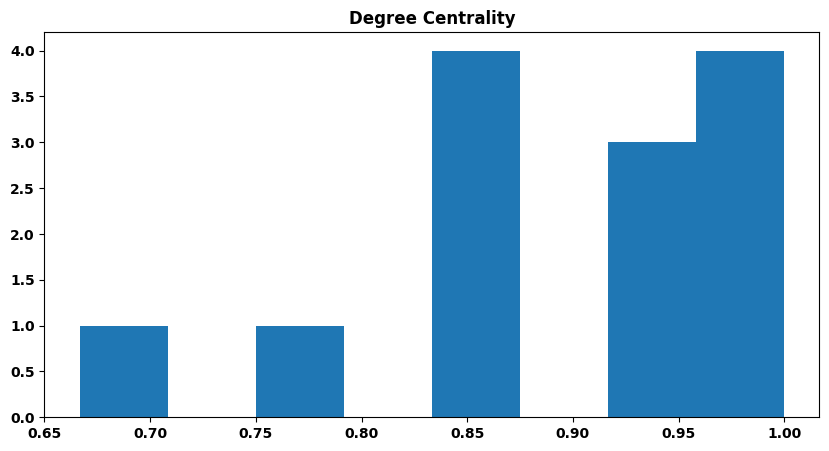

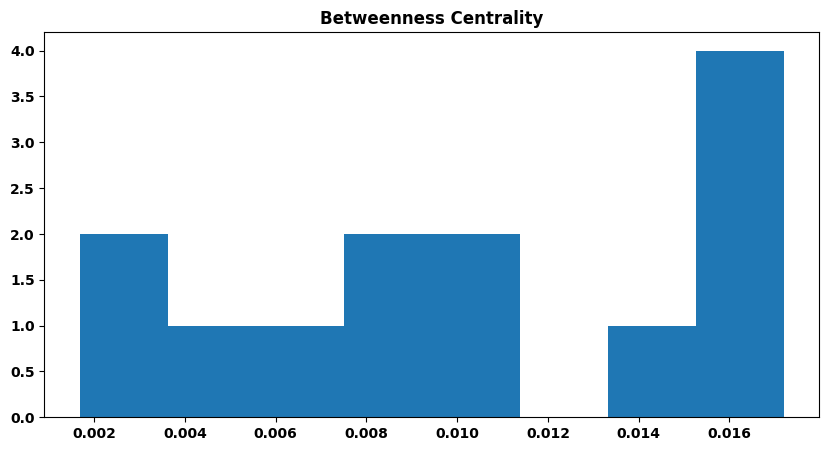

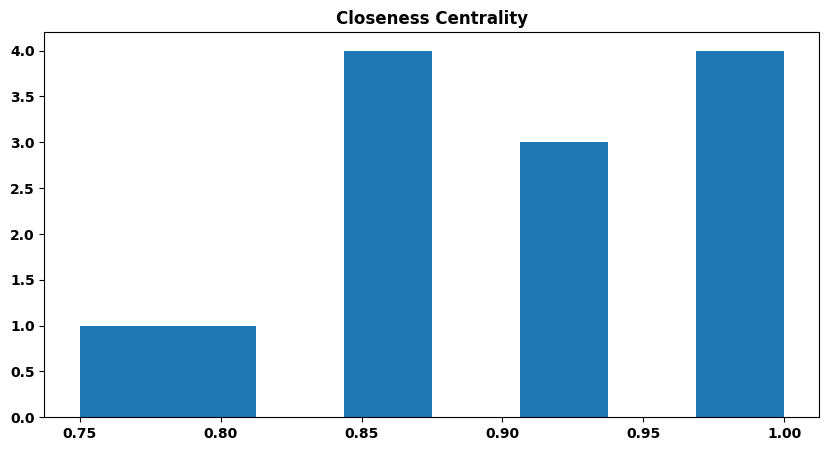

[frozenset({1, 2, 3, 4, 6, 8, 9, 10, 11}), frozenset({0, 5, 7, 12})]

In [72]:
# create a graph from the moves_df dataframe
moves_graph_2015_2017 = nx.from_pandas_edgelist(
    moves_df, source="2015", target="2017", edge_attr=True
)

# Create a graph from the moves_df dataframe for 2015 to 2016
moves_graph_2015_2016 = nx.from_pandas_edgelist(
    moves_df, source="2015", target="2016", edge_attr=True
)

# Create a graph from the moves_df dataframe for 2016 to 2017
moves_graph_2016_2017 = nx.from_pandas_edgelist(
    moves_df,
    source="2016",
    target="2017",
    edge_attr=True,
)

# get the nodes and edges of the graph
nodes = hv.Graph.from_networkx(moves_graph_2015_2017, nx.layout.spring_layout).opts(
    node_size=10,
    edge_line_width=0.5,
    node_color="black",
    edge_color="black",
    bgcolor="white",
    width=800,
    height=800,
)

edges = hv.Graph.from_networkx(moves_graph_2015_2017, nx.layout.spring_layout).opts(
    node_size=10,
    edge_line_width=0.5,
    node_color="black",
    edge_color="black",
    bgcolor="white",
    width=800,
    height=800,
)

nodes * edges

degree_centrality = nx.degree_centrality(moves_graph_2015_2017)
betweenness_centrality = nx.betweenness_centrality(moves_graph_2015_2017)
closeness_centrality = nx.closeness_centrality(moves_graph_2015_2017)

degree_centrality
betweenness_centrality
closeness_centrality

# Degree Centrality
plt.figure(figsize=(10, 5))
plt.hist(degree_centrality.values(), bins=8)
plt.title("Degree Centrality")
plt.show()

# Betweenness Centrality
plt.figure(figsize=(10, 5))
plt.hist(betweenness_centrality.values(), bins=8)
plt.title("Betweenness Centrality")
plt.show()

# Closeness Centrality
plt.figure(figsize=(10, 5))
plt.hist(closeness_centrality.values(), bins=8)
plt.title("Closeness Centrality")
plt.show()

communities = community.greedy_modularity_communities(moves_graph_2015_2017)
communities

In [73]:
def process_dog_count(dog_owner_df):
    """
    Process the dog count data from the given DataFrame.

    Args:
        dog_owner_df (pandas.DataFrame): DataFrame containing dog owner data.

    Returns:
        pandas.DataFrame: Processed DataFrame with dog count information.
    """

    # Get a subframe of the dog_count
    dog_count_df = dog_owner_df[["roster", "dog_count", "holder_id"]]

    # Pivot the dog count data
    dog_count_pivot = (
        dog_count_df.drop_duplicates()
        .pivot(columns="roster", values="dog_count", index="holder_id")
        .reset_index()
    )

    # Fill missing values with 0
    dog_count_pivot = dog_count_pivot.fillna(0)

    # Rename columns
    dog_count_pivot = dog_count_pivot.rename(
        columns={
            "2015": "dog_count_2015",
            "2016": "dog_count_2016",
            "2017": "dog_count_2017",
        }
    )

    # Calculate dog count changes
    dog_count_pivot["dog_count_change_2016"] = (
        dog_count_pivot["dog_count_2016"] - dog_count_pivot["dog_count_2015"]
    )
    dog_count_pivot["dog_count_change_2017"] = (
        dog_count_pivot["dog_count_2017"] - dog_count_pivot["dog_count_2016"]
    )

    # Sort by dog count changes
    dog_count_pivot.sort_values(
        by=["dog_count_change_2017", "dog_count_change_2016"], ascending=False
    )

    # Filter rows with zero dog count in 2015 and 2016
    dog_count_pivot_filtered = dog_count_pivot.loc[
        (dog_count_pivot["dog_count_2015"] == 0)
        & (dog_count_pivot["dog_count_2016"] == 0)
    ].sort_values(
        by=["dog_count_change_2017", "dog_count_change_2016"], ascending=False
    )

    return dog_count_pivot_filtered


process_dog_count(dog_owner_df)

roster,holder_id,dog_count_2015,dog_count_2016,dog_count_2017,dog_count_change_2016,dog_count_change_2017
3933,132195,0.0,0.0,4.0,0.0,4.0
1808,119973,0.0,0.0,3.0,0.0,3.0
3771,130989,0.0,0.0,3.0,0.0,3.0
4012,132456,0.0,0.0,3.0,0.0,3.0
4105,132963,0.0,0.0,3.0,0.0,3.0
...,...,...,...,...,...,...
7361,97427,0.0,0.0,1.0,0.0,1.0
7395,98164,0.0,0.0,1.0,0.0,1.0
7521,99059,0.0,0.0,1.0,0.0,1.0
7580,99306,0.0,0.0,1.0,0.0,1.0


##### HeatMaps

In [74]:
# the top 10 small breeds in Zurich


ktopn = (
    dog_owner_df[dog_owner_df["breed_type"] == "K"]["standard"]
    .value_counts()
    .head(10)
    .index.tolist()
)


# The top 10 big breeds in Zurich
itopn = (
    dog_owner_df[dog_owner_df["breed_type"] == "I"]["standard"]
    .value_counts()
    .head(10)
    .index.tolist()
)

hv.opts.defaults(
    hv.opts.HeatMap(
        tools=["hover", "tap", "box_select"],
        active_tools=["box_zoom"],
        width=800,
        height=500,
        ylabel="",
        line_color="white",
        line_width=2,
        toolbar="above",
    )
)

In [75]:
# Define the widget
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017"], name="Roster", width=250
)
# Create a checkbox widget
show_labels_checkbox = pnw.Checkbox(name="Show Annotations", value=True)

# state the breeds that we wnat in the heatmap
small_heatmap_breeds = [
    "french bulldog",
    "poodle",
    "labrador retriever",
    "mixed breed large",
    "german shepherd dog",
]

small_heatmap_breeds = ktopn

# group by roster also and see how the distribution changes
small_breeds_df = dog_owner_df[dog_owner_df["standard"].isin(small_heatmap_breeds)]


small_heatmap_breed_count = (
    small_breeds_df.groupby(["standard", "district", "roster"])
    .size()
    .reset_index(name="size")
)


# Define a function to create a heatmap
def get_small_heatmap(roster, show_labels):
    small_df = small_heatmap_breed_count[small_heatmap_breed_count["roster"] == roster]
    small_heatmap = hv.HeatMap(small_df, ["district", "standard"], "size").redim(
        standard="small_standard"
    )
    small_heatmap.opts(
        # **heatmap_opts,
        # cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top small breeds in {roster} by district",
        clim=(
            small_heatmap_breed_count["size"].min(),
            small_heatmap_breed_count["size"].max(),
        ),
    )
    if show_labels:
        labels = hv.Labels(small_df, ["district", "standard"], "size").opts(
            text_color="crimson"
        )
        return small_heatmap * labels
    return small_heatmap


small_dynamic_heatmap = pn.bind(
    get_small_heatmap,
    roster=roster_slider.param.value,
    show_labels=show_labels_checkbox.param.value,
)
# pn.panel(small_dynamic_heatmap)

In [76]:
large_heatmap_breeds = itopn

large_breed_df = dog_owner_df[dog_owner_df["standard"].isin(large_heatmap_breeds)]
large_heatmap_breed_count = (
    large_breed_df.groupby(["standard", "district", "roster"])
    .size()
    .reset_index(name="size")
)


def get_large_heatmap(roster, show_labels):
    large_df = large_heatmap_breed_count[large_heatmap_breed_count["roster"] == roster]
    large_heatmap = hv.HeatMap(large_df, ["district", "standard"], "size").redim(
        standard="large_standard"
    )
    large_heatmap.opts(
        # **heatmap_opts,
        # cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top large breeds in {roster} by district",
        clim=(
            large_heatmap_breed_count["size"].min(),
            large_heatmap_breed_count["size"].max(),
        ),
    )
    if show_labels:
        labels = hv.Labels(large_df, ["district", "standard"], "size").opts(
            text_color="crimson"
        )
        return large_heatmap * labels
    return large_heatmap


# Bind the widget to the function

large_dynamic_heatmap = pn.bind(
    get_large_heatmap,
    roster=roster_slider.param.value,
    show_labels=show_labels_checkbox.param.value,
)
# pn.panel(large_dynamic_heatmap)

# Create a Panel layout
# pn.Row(pn.Column(roster_slider, show_labels_checkbox), dynamic_heatmap)

In [77]:
# do a heatmap for the age_group and district by roster
# group by roster also and see how the distribution changes
age_group_count = (
    dog_owner_df.groupby(["age_group", "district", "roster"])
    .size()
    .reset_index(name="size")
)
age_group_count_ds = hv.Dataset(age_group_count)
# display(age_group_count)


# Create a checkbox widget
# show_labels_checkbox = pn.widgets.Checkbox(name="Show Labels", value=True)
def get_age_heatmap(roster):
    age_df = age_group_count[age_group_count["roster"] == roster]
    heatmap = hv.HeatMap(age_df, ["district", "age_group"], "size")
    heatmap.opts(
        # **heatmap_opts,
        cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_select"],
        title=f"Owner Age-group distribution in {roster}",
    )
    return heatmap


def get_age_heatmap_overlay(roster, show_labels):
    age_df = age_group_count[age_group_count["roster"] == roster]
    heatmap = hv.HeatMap(age_df, ["district", "age_group"], "size")
    heatmap.opts(
        # **heatmap_opts,
        cmap=cc.dimgray[::-1],
        colorbar=True,
        active_tools=["box_select"],
        title=f"Owner Age-group distribution in {roster}",
    )
    if show_labels:
        labels = hv.Labels(age_df, ["district", "age_group"], "size").opts(
            text_color="crimson", text_alpha=1
        )
    else:
        labels = hv.Labels(age_df, ["district", "age_group"], "size").opts(
            text_color="crimson", text_alpha=0
        )
    return heatmap * labels


# Bind the widget and the checkbox to the function
age_group_heatmap_overlay = hv.DynamicMap(
    pn.bind(
        get_age_heatmap_overlay,
        roster=roster_slider.param.value,
        show_labels=show_labels_checkbox.param.value,
    )
)
age_group_heatmap = hv.DynamicMap(
    pn.bind(get_age_heatmap, roster=roster_slider.param.value)
)
# pn.Row(show_labels_checkbox, age_group_heatmap)

In [123]:
import math

pn.state.kill_all_servers()
# Bar Plot which shows the top 10 breeds for each district and age group as it is selected in the heatmap
# Create a Tap stream linked to the HeatMap
tap = streams.Tap(source=age_group_heatmap, x=1, y="11-30")


@pn.depends(tap.param.x, tap.param.y, roster_slider.param.value)
def update_barplot(x, y, roster):
    new_x = math.ceil(x - 0.5)
    selected_data = age_group_count[
        (age_group_count["district"] == new_x) & (age_group_count["age_group"] == y)
    ]
    bar_data = dog_owner_df.loc[
        (dog_owner_df["district"] == new_x)
        & (dog_owner_df["age_group"] == y)
        & (dog_owner_df["roster"] == roster)
    ]
    # group data to get the count of each breed
    bar_data = (
        bar_data.groupby(["standard"])
        .size()
        .reset_index(name="count")
        .sort_values(by="count", ascending=False)
        .head(10)
    )
    return hv.Bars(bar_data, kdims=["standard"], vdims="count").opts(
        height=500,
        width=800,
        invert_axes=True,
        cmap=explicit_mapping,
        show_legend=False,
        xlabel="",
        color="standard",
        fontscale=1.5,
        title=f"Age-groups:{y} | Districts:{new_x}",
    )


update_barplot_panel = pn.panel(update_barplot)
# update_barplot_panel

In [124]:
pn.state.kill_all_servers()
# Create a Panel layout

pn.Row(
    pn.Column(roster_slider, show_labels_checkbox, width=300),
    pn.Column(pn.panel(age_group_heatmap), update_barplot_panel),
    pn.panel(small_dynamic_heatmap),
    pn.panel(large_dynamic_heatmap),
).show()

Launching server at http://localhost:62035


In [80]:
# check for correlation between age and dog_age
dog_owner_df["age_range_number"] = dog_owner_df["age_range"].cat.codes

dog_owner_df["age_range_number"].corr(dog_owner_df["dog_age"])

0.3050402014927059

In [111]:
# dog_owner_df["age_group"].cat.codes
dog_owner_df["age_group_number"] = dog_owner_df["age_group"].cat.codes
# check for a correlation between the age_group and the dog_age
dog_owner_df["age_group_number"].corr(dog_owner_df["dog_age"])
# check for a correlation between the age_group and the dog_age but for specific breeds and for each roster
print("Correlation between age_group and dog_age for small breeds: ")

correlations = []
for breed in ktopn:
    for roster in ["2015", "2016", "2017"]:
        breed_roster_df = dog_owner_df[
            (dog_owner_df["standard"] == breed) & (dog_owner_df["roster"] == roster)
        ]
        correlation = breed_roster_df["age_range_number"].corr(
            breed_roster_df["dog_age"]
        )
        correlations.append((breed, roster, correlation))

pivot_df = (
    pd.DataFrame(correlations, columns=["breed", "roster", "correlation"])
    .pivot(columns="roster", index="breed", values="correlation")
    .reset_index()
)

pivot_df



Correlation between age_group and dog_age for small breeds: 


roster,breed,2015,2016,2017
0,chihuahua,0.276248,0.264729,0.200085
1,dachshund,0.393888,0.437033,0.408378
2,french bulldog,0.293189,0.287967,0.280504
3,jack russell terrier,0.284413,0.320286,0.263081
4,maltese,0.213117,0.159609,0.190394
5,mixed breed small,0.282963,0.295512,0.298554
6,poodle,0.218467,0.200144,0.254061
7,pug,0.325054,0.315597,0.245546
8,west highland white terrier,0.282349,0.264952,0.159214
9,yorkshire terrier,0.369813,0.356388,0.283087


In [82]:
# group by roster and district and get the number of dogs in each district
district_dog_owners = dog_owner_df.groupby(["roster", "district"]).size().reset_index()
district_dog_owners.rename(columns={0: "dog_count"}, inplace=True)
# plot a bar chart of the number of dogs in each district groupby roster
# plot the bars for each roster in ta separate row in one layout using holoviews
bars = [
    district_dog_owners[district_dog_owners["roster"] == roster]
    .hvplot.bar(
        x="district",
        y="dog_count",
        title=f"Number of dogs in each district in {roster}",
        xlabel="",
        ylabel="Number of dogs",
        tools=["hover"],
        width=600,
        height=300,
    )
    .opts(
        active_tools=["box_zoom"],
    )
    for roster in district_dog_owners["roster"].unique()
]
hv.Layout(bars).cols(1)

district_dog_owners.hvplot(
    x="district",
    y="dog_count",
    by="roster",
    kind="bar",
    stacked=False,
    rot=90,
    legend=True,
    tools=["hover"],
    width=800,
    height=500,
    title="Number of dog owners in each district",
).opts(
    active_tools=["box_zoom"],
)

:Bars   [district,roster]   (dog_count)

In [83]:
dog_owner_df.groupby(["roster", "district"]).size().reset_index().query(
    "roster == '2015'"
)[0].sum()

6975

In [187]:
# Group by standard and roster, and calculate the size for each group
df_breed_counts = (
    dog_owner_df[dog_owner_df["standard"].isin(ktopn)]
    .groupby(["standard", "roster"])
    .size()
    .reset_index(name="size")
)

In [195]:
def create_overlay(
    df_breed_counts,
    color_mapping=explicit_mapping,
    x_col="roster",
    y_col="size",
    color_col="standard",
):
    points = hv.Points(df_breed_counts, [x_col, y_col], color_col).opts(
        color="standard",
        cmap=color_mapping,
        width=800,
        height=500,
        size=8,
        legend_position="right",
        tools=["hover"],
    )

    # Create a Curve for each 'standard' and then overlay them
    curves = hv.NdOverlay(
        {
            standard: hv.Curve(data, x_col, y_col).opts(color=color_mapping[standard])
            for standard, data in df_breed_counts.groupby(color_col)
        }
    )

    # Overlay the points on the curves
    plot = curves * points

    return plot

In [196]:
create_overlay(df_breed_counts, explicit_mapping)

:Overlay
   .NdOverlay.I :NdOverlay   [Element]
      :Curve   [roster]   (size)
   .Points.I    :Points   [roster,size]   (standard)

In [189]:
# calculate the percentage change in the number of dogs for each breed
df_trend_pivot = df_breed_counts.pivot(
    index="standard", columns="roster", values="size"
)
df_breed_trend = (
    df_trend_pivot.T.pct_change().T.fillna(0).stack().reset_index(name="pct_change")
)
pct_change_overlay = create_overlay(
    df_breed_trend, explicit_mapping, x_col="roster", y_col="pct_change"
)

zero_line = hv.HLine(0).opts(
    line_dash="dashed",
    line_color="lightgray",
)
(pct_change_overlay * zero_line).opts(title="Top Breeds Percent Change YOY")

:Overlay
   .NdOverlay.I :NdOverlay   [Element]
      :Curve   [roster]   (pct_change)
   .Points.I    :Points   [roster,pct_change]   (standard)
   .HLine.I     :HLine   [x,y]

In [190]:
# Define the breeds to highlight
highlight_breeds = ["chihuahua", "french bulldog", "poodle"]

# Calculate the percentage change for each breed from year to year
df_trend_pivot_pct_change = df_trend_pivot.pct_change(axis="columns").fillna(0)


# Plot the highlighted breeds
highlight_line_plot = df_trend_pivot_pct_change.loc[highlight_breeds].T.hvplot(
    kind="line", legend="right"
)
highlight_dot_plot = df_trend_pivot_pct_change.loc[highlight_breeds].T.hvplot.scatter(
    legend="right"
)

# Plot the other breeds
other_line_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot(
    kind="line", legend="right", color="lightgray"
)
other_dot_plot = df_trend_pivot_pct_change.drop(highlight_breeds).T.hvplot.scatter(
    legend="right", color="lightgray"
)

# add in the zero like  dotted
zero_line = hv.HLine(0).opts(line_dash="dashed", line_color="lightgray")
# zero_line * line_plot_pct_change * dot_plot_pct_change
# line_plot_pct_change * dot_plot_pct_change

# Combine the plots
(
    zero_line
    * other_line_plot
    * other_dot_plot
    * highlight_line_plot
    * highlight_dot_plot
).opts(
    title="Percent Change in Breeds YOY",
)

:Overlay
   .HLine.I       :HLine   [x,y]
   .NdOverlay.I   :NdOverlay   [standard]
      :Curve   [roster]   (value)
   .NdOverlay.II  :NdOverlay   [standard]
      :Scatter   [roster]   (value)
   .NdOverlay.III :NdOverlay   [standard]
      :Curve   [roster]   (value)
   .NdOverlay.IV  :NdOverlay   [standard]
      :Scatter   [roster]   (value)

In [ ]:
gdf["centroid"] = gdf.to_crs(ccrs.GOOGLE_MERCATOR).geometry.centroid.to_crs(epsg=4326)
gdf["lon"], gdf["lat"] = gdf["centroid"].x, gdf["centroid"].y
districts_pts = gdf.hvplot.points(
    x="lon",
    y="lat",
    geo=True,
    tiles="OSM",
    hover_cols=["kname"],
    alpha=0.5,
    color="skyblue",
    size=200,
    title="Zurich Districts",
    width=800,
    height=500,
    tools=["tap"],
    selection_line_color="black",
    selection_fill_color="red",
)

In [ ]:
pn.state.kill_all_servers()

# On a map of Zurich, plot the number of dogs in each district
# show any trend is clear like observed with the line plot with the French Bulldog and Chihuahua
# plot the distribution by roster
poly_opts = dict(
    width=800,
    height=500,
    tools=["hover", "tap", "box_select"],
    line_width=2,
    xaxis=None,
    yaxis=None,
    # cmap=explicit_mapping,
    # projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=400,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",
    xlabel="",
    cmap=explicit_mapping,
    show_legend=False,
    active_tools=["box_zoom"],
)


z_gdf = gdf.drop(columns=["objid", "kname"]).rename(
    columns={"knr": "district"})
z_gdf = z_gdf.set_index(z_gdf.district)

z_set = gv.Dataset(z_gdf)
zurich_poly = gv.Polygons(z_set).opts(**poly_opts, selection_color="pink")
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")

# define the function to get the breed counts
basemap * zurich_poly

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (district,km2)

In [ ]:
pn.state.kill_all_servers()


# get the count of the french bulldog in each district for each roster and plot it
# plot it on a dynamic map with a slider for the roster
def get_breed_count(breed, roster):
    df = dog_owner_df[
        (dog_owner_df["standard"] == breed)
        & (dog_owner_df["roster"].str.contains(roster))
    ]
    df = df.groupby("district").size().reset_index(name="count")
    df = df.set_index("district")

    breed_gdf = z_gdf.merge(df, left_index=True, right_index=True, how="left")
    breed_color = explicit_mapping[breed]
    # Start from white and go to the breed color
    colors = [(1, 1, 1), breed_color]

    new_cmap = LinearSegmentedColormap.from_list("breed_cmap", colors)

    return gv.Polygons(breed_gdf).opts(
        **poly_opts,
        color="count",
        cmap=new_cmap,
        clim=(0, 40),
        colorbar=True,
        title=f"{breed} in {roster}",
    )


standard_selecter = pnw.Select(name="Breed", options=ktopn, value="french bulldog")
# create the dynamic map
dmap = gv.DynamicMap(
    pn.bind(get_breed_count, breed=standard_selecter, roster=roster_slider)
)
pn.Column(standard_selecter, pn.Row(roster_slider, basemap * dmap)).show()

Launching server at http://localhost:59764


In [ ]:
num_dog_owners = dog_owner_df.holder_id.nunique()  # 7720
dog_owner_df[["standard", "roster", "roster_count", "holder_id"]].sort_values(
    "holder_id"
)
# owners each roster
dog_owner_df.groupby(["roster"])["holder_id"].nunique()

# french bulldog owners each roster
french_bulldog_owner_df = (
    dog_owner_df[
        dog_owner_df["standard"].str.contains(
            "french bulldog", case=False, regex=True, na=False
        )
    ]
    .groupby(["roster"])["holder_id"]
    .unique()
)

In [ ]:
def get_breed_owners_stats(dog_owner_df, breed):
    """Func for the row with the stats for the breed new, returning, and left owner numbers"""
    if breed == "all":
        breed_owner_df = dog_owner_df.copy()
    else:
        breed_owner_df = dog_owner_df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    owner_stats = {}
    for year in ["2015", "2016", "2017"]:
        breed_owner_year = get_owners(breed_owner_df, year)
        owner_stats[year] = len(breed_owner_year)

        if year != "2015":
            prev_year = str(int(year) - 1)
            breed_owner_prev_year = get_owners(breed_owner_df, prev_year)

            new_owners = get_new_owners(breed_owner_year, breed_owner_prev_year)
            returning_owners = get_returning_owners(
                breed_owner_year, breed_owner_prev_year
            )
            left_owners = get_left_owners(breed_owner_year, breed_owner_prev_year)

            owner_stats[f"new_{year}"] = len(new_owners)
            owner_stats[f"returning_{year}"] = len(returning_owners)
            owner_stats[f"left_{year}"] = len(left_owners)

    # constant owners for all 3 years
    constant_owners = (
        get_owners(breed_owner_df, "2015")
        .intersection(get_owners(breed_owner_df, "2016"))
        .intersection(get_owners(breed_owner_df, "2017"))
    )
    owner_stats["constant_owners"] = len(constant_owners)

    gap_owners = (
        get_owners(breed_owner_df, "2015")
        .intersection(get_owners(breed_owner_df, "2017"))
        .difference(get_owners(breed_owner_df, "2016"))
    )
    owner_stats["gap_owners"] = len(gap_owners)
    # change the order of columns to make it more readable
    owner_stats = {
        "breed": breed,
        "constant_owners": owner_stats["constant_owners"],
        "gap_owners": owner_stats["gap_owners"],
        "2015": owner_stats["2015"],
        "2016": owner_stats["2016"],
        "2017": owner_stats["2017"],
        "new_2016": owner_stats["new_2016"],
        "returning_2016": owner_stats["returning_2016"],
        "left_2016": owner_stats["left_2016"],
        "new_2017": owner_stats["new_2017"],
        "returning_2017": owner_stats["returning_2017"],
        "left_2017": owner_stats["left_2017"],
    }

    return pd.DataFrame(owner_stats, index=[0])


# Usage:
french_bulldog_stats = get_breed_owners_stats(dog_owner_df, "french bulldog")
get_breed_owners_stats(dog_owner_df, "all")
top_breeds = ktopn + itopn
top_breeds
# breed_owner_stats_list = [
#     get_breed_owners_stats(dog_owner_df, breed) for breed in top_breeds
# ]

NameError: name 'get_owners' is not defined

In [ ]:
dog_owner_df.columns

In [ ]:
# Owner ins and outs for the top 10 breeds
pd.concat(
    [get_breed_owners_stats(dog_owner_df, breed) for breed in ktopn], axis=0
).reset_index(drop=True)
pd.concat(
    [get_breed_owners_stats(dog_owner_df, breed) for breed in itopn], axis=0
).reset_index(drop=True)

breed_ii_owners = set(
    dog_owner_df.loc[(dog_owner_df["breed_type"] == "II")]["holder_id"].tolist()
)
dog_owner_df.loc[dog_owner_df["holder_id"].isin(breed_ii_owners)].sort_values(
    "holder_id"
)

In [ ]:
dog_owner_df[(dog_owner_df["breed_type"] == "II")].groupby(
    ["standard", "roster"]
).size().unstack().sort_values(by="2017", ascending=False)

In [ ]:
dog_owner_df.groupby(["age", "roster"]).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Owners age distribution each roster",
).opts(active_tools=["box_select"])

In [ ]:
# define func tostep plot, kde and barplot of age_range by breed query
def plot_age_range_stats(df, breed, bw, pure_breed):
    """Function to plot the age_range stats for the breed owners"""
    if pure_breed:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False) & pure_breed == True'
        )
    else:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )

    # plot a step plot of the dog_age
    step = (
        breed_df.groupby(["dog_age", "roster"])
        .size()
        .unstack()
        .hvplot.step(
            title=f"Dog Age distribution of {breed}",
        )
    )

    # plot age_range of breed_df kde plot
    kde = breed_df.hvplot.kde(
        y="dog_age",
        by="roster",
        bandwidth=bw,
        xlim=(0, 20),
        muted_alpha=0.01,
        title=f"Dog Age distribution of {breed}",
    )
    # plot age_range of breed_df bar plot
    bar = (
        breed_df.groupby(["age_range", "roster"])
        .size()
        .unstack()
        .hvplot.bar(
            rot=90,
            legend=True,
            tools=["hover", "box_select"],
            title=f"Owner of {breed} Age distribution",
        )
        .opts(active_tools=["box_select"])
    )
    return (step + kde + bar).cols(1)


# create widgets for the breed, bandwidth
breed_selector = pnw.Select(name="Breed", options=ktopn, value="french bulldog")
bandwidth_slider = pnw.FloatSlider(
    name="Bandwidth", start=0.1, end=2, step=0.1, value=0.5
)
pure_breed_checkbox = pnw.Checkbox(name="Pure Breed", value=True)

# create a dynamic map
dynamic_age_plot = pn.bind(
    plot_age_range_stats,
    df=dog_owner_df,
    breed=breed_selector,
    bw=bandwidth_slider,
    pure_breed=pure_breed_checkbox,
)

In [ ]:
pn.state.kill_all_servers()
# create a panel layout
pn.Column(
    breed_selector, bandwidth_slider, pure_breed_checkbox, dynamic_age_plot
).show()

In [ ]:
# Define the widget
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017"], name="Roster")
district_slider = pnw.IntSlider(name="District", value=1, start=1, end=12)


selection_stream = streams.Selection1D(source=zurich_poly)


def get_barplot(roster, district):
    # Get the data for the selected district and roster
    df = (
        dog_owner_df[
            (dog_owner_df["district"] == district) & (
                dog_owner_df["roster"] == roster)
        ]
        .groupby("standard")
        .size()
        .sort_values(ascending=False)
        .reset_index(name="count")
        .head()
    )

    # Create the barplot
    barplot = hv.Bars(df, "standard", "count").opts(
        **bar_opts,
        color="standard",
        title=f"Top 5 breeds in {roster} in district {district}",
    )
    lables = hv.Labels(df, ["standard", "count"], "standard").opts(
        text_font_size="14pt", text_color="white", text_align="right"
    )
    return barplot


bar_panel = pn.panel(
    pn.bind(get_barplot, roster=roster_slider, district=district_slider)
)

In [ ]:
bar_panel